In [1]:
function ruleGen(rule::Int)
    rule = digits(rule, base=2, pad=8)
    rules = Dict{Array{Bool,1}, Bool}()
    
    for i in 0:7
        x = digits(i, base=2, pad=3)
        #println(rule[i+1], " -> ", x)
        rules[[x[3], x[2], x[1]]] = rule[i+1]
    end
    
    return rules
end

ruleGen (generic function with 1 method)

In [3]:
function CA(rule::Int, seed::Array{Bool,1}, iterations::Int)
    if !(rule >= 0 && rule <= 255)
        error("Incorrect rule [0-255]")
    end
    
    if (iterations < 1)
        error("Must have positive iterations.")
    end
    
    rules = ruleGen(rule)
    
    n = length(seed)
    result = falses(n,iterations+1)
    state = falses(3)
    
    result[:,1] = seed
    
    for it in 2:iterations+1
        for i in 1:n
            left = mod1(i-1, n)
            right = mod1(i+1, n)
            
            state[1] = result[left, it-1]
            state[2] = result[i, it-1]
            state[3] = result[right, it-1]
            
            result[i, it] = rules[state]
        end
    end
    
    return result
end

function CA(rule::Int, seed::BitArray{1}, iterations::Int)
    seed = convert(Array{Bool,1}, seed)
    
    return CA(rule, seed, iterations)
end

CA (generic function with 2 methods)

In [4]:
function resistance(caState::BitArray{2}, resistanceMat::Array{<:Real,2})
    for i in resistanceMat
        if i == 0.0
            error("Resistance matrix must be on positive domain")
        end
    end
    
    if size(caState) != size(resistanceMat)
        error("CA State and Resistance state have size mismatch.")
    end
    
    invsum = Float64(0.0)
    
    for i in 1:length(resistanceMat)
        if caState[i]
            invsum += 1/resistanceMat[i]
        end
    end
    
    if invsum != 0
        return 1/invsum
    else
        return Inf
    end
end

resistance (generic function with 1 method)

In [5]:
using PyPlot, Optim

┌ Info: Recompiling stale cache file /home/wilkie/.julia/compiled/v0.7/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1185


In [27]:
function linear_fitness(r::Array{<:Real,1})
    n = 8
    rule = 90
    
    if length(r) != n^2
        error("Wrong resistance matrix length.")
    end
    
    
    #set up the low values
    a = [falses(n) for i in 1:3]
    a[1][end] = true
    a[2][end-1] = true
    a[3][end-1:end] .= true
    
    #set up the high values
    b = [trues(n) for i in 1:3]
    b[1][end] = false
    b[2][end-1] = false
    b[3][end-1:end] .= false
    
    ca_a = [CA(rule, a[i], n-1) for i in 1:3]
    ca_b = [CA(rule, b[i], n-1) for i in 1:3]

    r_a = [resistance(ca_a[i], reshape(r,n,n)) for i in 1:3]
    r_b = [resistance(ca_b[i], reshape(r,n,n)) for i in 1:3]
    
    distance = 0.0
    for i in 1:3, j in 1:3
        distance += abs(r_a[i] - r_b[j])
    end

    return -1*distance
end


linear_fitness (generic function with 1 method)

In [42]:
function linear_verify(r::Array{<:Real,1})
    n = 8
    rule = 90
    
    if length(r) != n^2
        error("Wrong resistance matrix length.")
    end
    
    
    #set up the low values
    a = [falses(n) for i in 1:3]
    a[1][end] = true
    a[2][end-1] = true
    a[3][end-1:end] .= true
    
    #set up the high values
    b = [trues(n) for i in 1:3]
    b[1][end] = false
    b[2][end-1] = false
    b[3][end-1:end] .= false
    
    ca_a = [CA(rule, a[i], n-1) for i in 1:3]
    ca_b = [CA(rule, b[i], n-1) for i in 1:3]

    r_a = [resistance(ca_a[i], reshape(r,n,n)) for i in 1:3]
    r_b = [resistance(ca_b[i], reshape(r,n,n)) for i in 1:3]
    
    return (r_a, r_b)
end

linear_verify (generic function with 1 method)

In [28]:
linear_fitness(ones(64))

-0.34141414141414145

In [30]:
linear_fitness(rand(64))

-0.1192684259947934

In [32]:
lower = ones(Float64, 64) .* 4000
upper = ones(Float64, 64) .* 12000;

In [34]:
test = optimize(linear_fitness, lower, upper, rand(64) .* 8000 .+ 4000)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [10291.09916800766,6912.321983501185, ...]
 * Minimizer: [8988.685628582261,4000.288590863426, ...]
 * Minimum: -4.982981e+03
 * Iterations: 10
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.18e-01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 33082
 * Gradient Calls: 33082

In [35]:
summary(test)

"Fminbox with L-BFGS"

In [38]:
r1 = reshape(Optim.minimizer(test), 8, 8)

8×8 Array{Float64,2}:
  8988.69  11184.8   12000.0   10421.1   …  11202.9    7354.98  5361.73
  4000.29   6961.26  10791.3   12000.0       8064.69   5863.48  5931.23
  4000.0    5996.01   9306.07  11153.1       8573.55   7443.63  4353.57
  4000.0    6267.52   6993.19  12000.0       9417.15  10474.5   9073.21
  4288.11  10100.0   10794.7    9869.38      5903.7    5338.55  7630.34
 10222.4   10238.0    9310.72  10221.5   …   7649.48  10268.6   8382.09
 12000.0   10004.4    8414.8    9501.16      8766.68   8752.43  8822.86
 12000.0   12000.0    7224.58  11603.0       7508.23  10464.0   4093.63

In [41]:
#set up the low values
a = [falses(8) for i in 1:3]
a[1][end] = true
a[2][end-1] = true
a[3][end-1:end] .= true

#set up the high values
b = [trues(8) for i in 1:3]
b[1][end] = false
b[2][end-1] = false
b[3][end-1:end] .= false

2-element view(::BitArray{1}, 7:8) with eltype Bool:
 false
 false

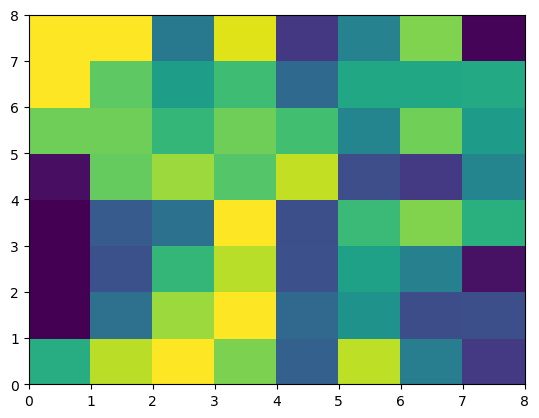

PyObject <matplotlib.collections.QuadMesh object at 0x7f3522153710>

In [39]:
pcolormesh(r1)

In [45]:
(linlow, linhigh) = linear_verify(vec(r1))

([1156.12, 1264.22, 603.879], [486.092, 504.22, 372.918])

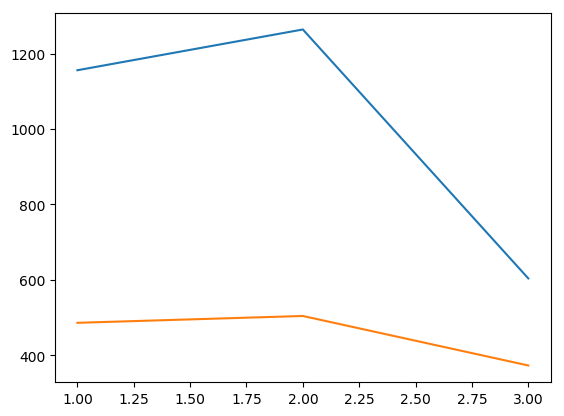

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3509e02a58>

In [47]:
plot(1:3, linlow)
plot(1:3, linhigh)

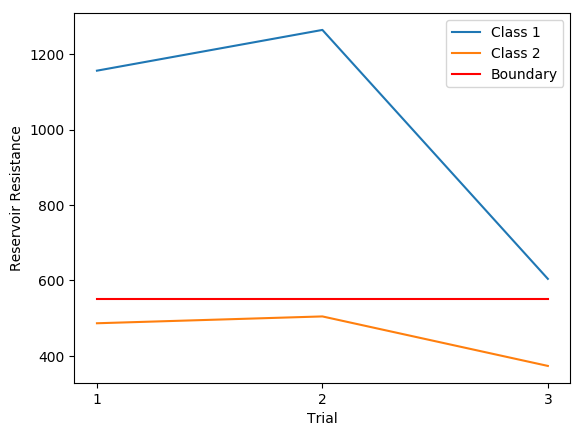

PyObject <matplotlib.legend.Legend object at 0x7f3509c0d2e8>

In [57]:
plot(1:3, linlow, label="Class 1")
plot(1:3, linhigh, label="Class 2")
ylabel("Reservoir Resistance")
xticks(collect(1:3), collect(1:3))
plot([1,3],[550,550],c="r",label="Boundary")
xlabel("Trial")
legend()

In [48]:
test2 = optimize(linear_fitness, lower, upper, rand(64) .* 4000 .+ 4000)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [6634.957562703715,5153.331762482784, ...]
 * Minimizer: [4000.0000000000005,4000.0000000000005, ...]
 * Minimum: -6.274510e+03
 * Iterations: 8
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 9.74e-02 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 105461
 * Gradient Calls: 105461

In [49]:
r2 = reshape(Optim.minimizer(test2), 8, 8)

8×8 Array{Float64,2}:
  4000.0  12000.0   12000.0   12000.0  8003.3   7997.93  7999.42  8001.44
  4000.0   8001.27  12000.0   12000.0  7998.72  7997.85  7998.15  8000.75
  4000.0   7998.32   7999.6   12000.0  8000.64  7999.94  7998.73  7998.54
  4000.0   7999.76   7996.01  12000.0  7998.88  8000.34  7998.1   7999.87
  4000.0   8000.64  12000.0   12000.0  7998.48  8002.41  7998.47  7998.34
  4000.0  12000.0   12000.0   12000.0  8001.4   8000.57  7997.85  8002.76
 12000.0  12000.0    7999.32  12000.0  7999.34  8001.34  8001.16  8001.53
 12000.0  12000.0    8000.78  12000.0  7999.61  7997.54  7998.0   8000.18

In [50]:
 linear_verify(vec(r2))

([1333.33, 1333.33, 666.667], [444.444, 444.444, 352.941])